# 1. Business understanding

Listing any type of property in AirBnb has become an important source of income for many owners, and also is an affordable acommodation option for travelers in a budget (although you can also find [castles](https://www.airbnb.com.co/rooms/9859896?_set_bev_on_new_domain=1614045046_YWZlODRlMTIwNzZi&source_impression_id=p3_1614045065_a6TPR4xPl0MoDwRs&guests=1&adults=1) and [islands](https://www.airbnb.com.co/rooms/1296802?_set_bev_on_new_domain=1614045046_YWZlODRlMTIwNzZi&source_impression_id=p3_1614045210_eUMTMwo0wunP4gz1))


## Boston?

The real reason behind the selection of Boston as an Airbnb study case is purely based in the Udacity Nanodregree recomendation, but there are some interesting fats surrounding the listings in this city.

- A 2016 study suggested that a 10% increase in Airbnb listings led to a 0.42% increase in rent prices being asked in that area. [fact 1](https://ipropertymanagement.com/research/airbnb-statistics)
- Boston is the 12th highest occupancy rate city in the U.S. [fact 2](https://www.stratosjets.com/blog/airbnb-statistics/)
- "...The new rules require that hosts own the properties they rent out, and live in them for at least nine months of the year." [fact 3](https://www.cnbc.com/2019/12/03/in-boston-airbnb-tasked-with-removing-thousands-of-illegal-listings.html)


## What data do we have?

The dataset has three archives to work with: 

- ***Listings***, including full descriptions and average review score
- ***Reviews***, including unique id for each reviewer and detailed comments
- ***Calendar***, including listing id and the price and availability for that day

## What question do we want to answer?

1. Is there is a strong correlation between the size of the listing and its price?
2. Is Location the most important variable for demand and pricing?
3. Past reviews impact future listings of the place?

# 2. Data Understanding

##  Environment and data

First af all, lets load all needed packages and teh data we will be working with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

df_lis = pd.read_csv('./listings.csv')
df_rev = pd.read_csv('./reviews.csv')
df_cal = pd.read_csv('./calendar.csv')




## Listings!

This dataset contais full descriptions of the listings and average review score



In [2]:
df_lis.shape

(3585, 95)

In [4]:
df_lis.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN


The datased has 95 variables for 3858 listings. It holds some interesting nonstructured data, like **summary**, **space** and **descripcion**. Although this variables surely have relevant information for the desition of the traveler, we will be focusing our efforts in understanding how numeric and categorical variables influence price. With this in mind we are going to be working with the columns selected in the next cell.

In [6]:
df_lis=df_lis[['id','host_since','host_response_time', 'host_response_rate','host_acceptance_rate',
                'host_is_superhost','host_total_listings_count','zipcode','latitude',
                'longitude','property_type','room_type','accommodates',
                'bathrooms','bedrooms','beds','bed_type','price',
                'security_deposit','guests_included','extra_people',
                'number_of_reviews', 'review_scores_rating','review_scores_accuracy',
                'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                'review_scores_location','review_scores_value','instant_bookable']]
df_lis.head(2)

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,zipcode,latitude,longitude,...,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
0,12147973,2015-04-15,NaN,NaN,NaN,f,1,02131,42.282619,-71.133068,...,$0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f
1,3075044,2012-06-07,within an hour,100%,100%,f,1,02131,42.286241,-71.134374,...,$0.00,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,t


### Lets do some EDA over Listings

Lets beging diferentiationg numeric and categorical variables

In [7]:
df_lis.dtypes

id                               int64
host_since                      object
host_response_time              object
host_response_rate              object
host_acceptance_rate            object
host_is_superhost               object
host_total_listings_count        int64
zipcode                         object
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
price                           object
security_deposit                object
guests_included                  int64
extra_people                    object
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin    

It seems we have some issues with the two variables 'price' and 'security_deposit'. We have to change the type to float but doing some replacements first.

In [8]:
df_lis['price'] = df_lis['price'].str.replace('$', '')
df_lis['price'] = df_lis['price'].str.replace(',', '')
df_lis['price']=df_lis['price'].astype('float')

df_lis['security_deposit'] = df_lis['security_deposit'].str.replace('$', '')
df_lis['security_deposit'] = df_lis['security_deposit'].str.replace(',', '')
df_lis['security_deposit']=df_lis['security_deposit'].astype('float')

df_lis['host_response_rate'] = df_lis['host_response_rate'].str.replace('%', '')
df_lis['host_response_rate']=df_lis['host_response_rate'].astype('float')

df_lis['host_acceptance_rate'] = df_lis['host_acceptance_rate'].str.replace('%', '')
df_lis['host_acceptance_rate']=df_lis['host_acceptance_rate'].astype('float')

In [9]:
# Here we split numeric and categorical variables in two datasets
l_num_vars = df_lis[df_lis.select_dtypes(include=['float', 'int']).columns]
l_cat_vars = df_lis[df_lis.select_dtypes(include=['object']).columns]

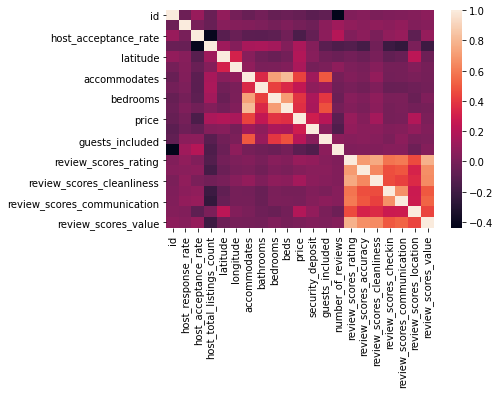

In [10]:
#Now lets plot some correlations
sns.heatmap(l_num_vars.corr())
plt.show()

There seem to be some obvoius correlations:

1. The scores have the biggest correlation between them.
2. Between the number of bedrooms and the number of bed.

But there are some that are not that simple:

1. It seems that the socre that are more correlate with price are location and cleanliness
2. Latitude seems to be more correlated with price that longitude

In [11]:
corr_lis=l_num_vars.corr().stack().reset_index()
corr_lis.columns = ['var_1','var_2','corr']
price_corr=corr_lis[corr_lis['var_1']=='price'].sort_values(by=['corr'])  
price_corr=price_corr[price_corr['var_2']!='price']

price_corr.style.bar(subset=['corr'], align='mid', color=['#d65f5f', '#5fba7d'])

,var_1,var_2,corr
212,price,host_acceptance_rate,-0.156908
223,price,number_of_reviews,-0.096427
210,price,id,-0.059198
211,price,host_response_rate,-0.007750
227,price,review_scores_checkin,-0.003851
228,price,review_scores_communication,0.003614
230,price,review_scores_value,0.011834
225,price,review_scores_accuracy,0.041204
224,price,review_scores_rating,0.105651
226,price,review_scores_cleanliness,0.146548


Checking correlations only with 'price' it is clear that the number of bedrooms/beds, therefore the size of the listing, is strongly correlated with the price. Location (latitude and longitude) have a some correlation with price.

## Reviews!

This dataset has unique id for each reviewer and detailed comments



In [12]:
df_rev.shape

(68275, 6)

In [13]:
df_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [14]:
df_rev=df_rev.drop(['id','date','reviewer_name'],axis=1)

In [15]:
df_rev

,listing_id,reviewer_id,comments
0,1178162,4298113,My stay at islam's place was really cool! Good...
1,1178162,6452964,Great location for both airport and city - gre...
2,1178162,6449554,We really enjoyed our stay at Islams house. Fr...
3,1178162,2215611,The room was nice and clean and so were the co...
4,1178162,6848427,Great location. Just 5 mins walk from the Airp...
...,...,...,...
68270,7462268,22034145,Joe y su mujer son encantadores. La habitación...
68271,7462268,40052513,Joe was on his way to Jamaica to be married! o...
68272,7462268,77129134,The room was very clean as were the bathrooms ...
68273,7462268,15799803,Staying in Lower Allston at Joe and Nancy's pl...


This dataset is pretty straight forward. In the following section we are going to try and use some sort of prebuilt sentimen analisys tool so we can clasify the comments and try to predict the price :). Here we can drop the reviwe and

## Calendar!

This table has listings id and the price and availability for a given day

In [130]:
df_cal.shape

(1308890, 4)

In [131]:
df_cal.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


# 3. Data Preparation

In [140]:
df_lis
df_rev
df_cal

id                               int64
host_since                      object
host_response_time              object
host_response_rate             float64
host_acceptance_rate           float64
host_is_superhost               object
host_total_listings_count        int64
zipcode                         object
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
price                          float64
security_deposit               float64
guests_included                  int64
extra_people                    object
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin    

# 4. Modeling

# 5. Results, Evaluation and Insights